In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import pickle
file_x = open('./dataverse_files/pristine_dataset_x.pkl', 'rb')
file_y = open('./dataverse_files/pristine_dataset_y.pkl', 'rb')
X = pickle.load(file_x, encoding='bytes')
Y = pickle.load(file_y, encoding='bytes')
Y = Y.reshape((Y.shape[0], 1))

In [4]:
from torch.utils.data import Dataset, TensorDataset
import torchvision
import torchvision.transforms as transforms

class FingerprintDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
    
    def __getitem__(self, index):
        x = self.samples[0][index]
        y = self.samples[1][index]
        
        if self.transform:
            x = self.transform(np.uint8(x*255.0))
        
        return x, torch.tensor(y)
    
    def __len__(self):
        return self.samples[0].shape[0]

In [5]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = FingerprintDataset((X, Y), transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

torch.Size([32, 3, 64, 64])


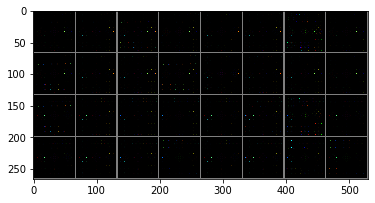

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images, nrow=8))

# for i in range (32):
#     print(labels[i])

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Net(nn.Module):
    def __init__(self, input_size=(3, 64, 64)):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (7, 7), padding=(3, 3)), # padding = (F-1)/2 (to keep the size constant) 
            nn.ReLU(),
            nn.Conv2d(32, 32, (7, 7), padding=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)), # 32
            nn.Conv2d(32, 16, (7, 7), padding=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(16, 16, (7, 7), padding=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)), # 16
            nn.Conv2d(16, 8, (7, 7), padding=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(8, 8, (7, 7), padding=(3, 3)),
            nn.ReLU()
        )
        
        self.flat_fts = self.get_flat_fts(input_size, self.features)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.flat_fts, 128),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 7),
            nn.Softmax(dim=1)
        )
        
    def get_flat_fts(self, in_size, fts):
        f = fts(Variable(torch.ones(1,*in_size)))
        return int(np.prod(f.size()[1:]))
    
    def forward(self, x):
        fts = self.features(x)
        flat_fts = fts.view(-1, self.flat_fts)
        out = self.classifier(flat_fts)
        return out

In [ ]:
net = Net()
net.to(device)

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [16]:
def train(trainloader, numEpochs):
    
    for epoch in range(numEpochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0], data[1]
            labels = labels.squeeze_()
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # print(inputs.shape)
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0

    print('Finished Training')

In [17]:
train(train_loader, 5)

[1,    10] loss: 1.947
[1,    20] loss: 1.936
[1,    30] loss: 1.919
[1,    40] loss: 1.945
[1,    50] loss: 1.956
[1,    60] loss: 1.938
[1,    70] loss: 1.912
[1,    80] loss: 1.867
[1,    90] loss: 1.804
[1,   100] loss: 1.710
[1,   110] loss: 1.588
[1,   120] loss: 1.454
[1,   130] loss: 1.348
[1,   140] loss: 1.919
[1,   150] loss: 2.139
[1,   160] loss: 2.136
[1,   170] loss: 2.133
[1,   180] loss: 2.125
[1,   190] loss: 2.114
[1,   200] loss: 2.099
[1,   210] loss: 2.079
[1,   220] loss: 2.055
[1,   230] loss: 2.096
[1,   240] loss: 2.082
[1,   250] loss: 2.069
[1,   260] loss: 2.070
[1,   270] loss: 2.051
[1,   280] loss: 2.028
[1,   290] loss: 1.995
[1,   300] loss: 1.955
[1,   310] loss: 1.899
[1,   320] loss: 1.821
[2,    10] loss: 2.054
[2,    20] loss: 2.044
[2,    30] loss: 2.029
[2,    40] loss: 1.956
[2,    50] loss: 1.896
[2,    60] loss: 1.827
[2,    70] loss: 1.730
[2,    80] loss: 1.601
[2,    90] loss: 1.467
[2,   100] loss: 1.350
[2,   110] loss: 1.277
[2,   120] 